# 0. Setup

In [2]:
import matplotlib.pyplot as plt
import keras.optimizers as optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras import models
from keras import regularizers
import math

2022-12-12 16:43:23.423991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Hyperparameters

In [3]:
input_height = 69
input_width = 69
batch_size = 64

# TODO: find best parameters using the display_data_augmentation_sample jupyter notebook
rescale = True
if rescale:
    rescale_size=1./255
else:
    rescale_size=1
augmentation=True

rotation_range=40
width_shift_range=0.2
height_shift_range=0.2
shear_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'
# consider also stride (>1), type of pooling (Max, Avg), padding (same, valid)

In [4]:
# best loss function for multi-class classification, measures the distance between two probability distributions
# the probability distribution of the output of the network and the true distribution of the labels
loss_function='categorical_crossentropy'

metrics=['accuracy']
optimizer='rmsprop'
optimizer_learning_rate=1e-4
epochs=5
batch_size=20
regularizer=regularizers.l1_l2(l1=0.001, l2=0.001) # simultaneous l1 and l2, add 0.001*weight_coefficient_value + 0.001 * 1/2*weight^2

if optimizer == 'rmsprop':
    optimizer=optimizers.RMSprop(learning_rate=optimizer_learning_rate)

# 2. Holdout method

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil
import os

In [6]:
paths = {
    'TRAIN_PATH' : os.path.join('workspace', 'images', 'train'),
    'TEST_PATH' : os.path.join('workspace', 'images','test'),
    'EVAL_PATH' : os.path.join('workspace', 'images','eval'),
    'IMAGES_PATH': os.path.join('workspace','images','all'),
    'ANNOTATION_PATH': os.path.join('workspace','annotations'),
    'LOG_DIR' : os.path.join('model', 'log_dir')
 }

In [7]:
# create paths
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [8]:
# remove all files already present for an old holdout method execution
for i in range(0,10):
    for file in os.listdir(os.path.join(paths["TRAIN_PATH"],str(i))):
        if file != ".DS_Store":
            os.remove(os.path.join(paths["TRAIN_PATH"],str(i), file))
    for file in os.listdir(os.path.join(paths["TEST_PATH"],str(i))):
        if file != ".DS_Store":
            os.remove(os.path.join(paths["TEST_PATH"],str(i), file))
    for file in os.listdir(os.path.join(paths["EVAL_PATH"],str(i))):
        if file != ".DS_Store":
            os.remove(os.path.join(paths["EVAL_PATH"],str(i), file))

df = pd.read_csv(os.path.join(paths['ANNOTATION_PATH'],"annotations.csv"))
df = df.dropna()

for i in range(0,10):
    if not os.path.exists(os.path.join(paths["EVAL_PATH"],str(i))):
        if os.name == 'posix':
            !mkdir -p {os.path.join(paths["EVAL_PATH"],str(i))}
    if not os.path.exists(os.path.join(paths["TRAIN_PATH"],str(i))):
        if os.name == 'posix':
            !mkdir -p {os.path.join(paths["TRAIN_PATH"],str(i))}
    if not os.path.exists(os.path.join(paths["TEST_PATH"],str(i))):
        if os.name == 'posix':
            !mkdir -p {os.path.join(paths["TEST_PATH"],str(i))}

# split in training set (90%) and test set (10%)
X_train, X_test, y_train, y_test = train_test_split(df, df, test_size=0.1, shuffle=True)
print("Train size: " + str(len(X_train)))

for index, row in X_test.iterrows():
    shutil.copy(os.path.join(paths["IMAGES_PATH"],str(row['Path'])),
                os.path.join(paths["TEST_PATH"],str(row['Class']),str(row['Path'])))

# split the training set into the final training set (80%) and validation set (20%)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
print("Test size: " + str(len(X_test)))
print("Eval size: " + str(len(X_eval)))

for index, row in X_train.iterrows():
    shutil.copy(os.path.join(paths["IMAGES_PATH"],str(row['Path'])),
                os.path.join(paths["TRAIN_PATH"],str(row['Class']),str(row['Path'])))

for _, row in X_eval.iterrows():
    shutil.copy(os.path.join(paths["IMAGES_PATH"],str(row['Path'])),
                os.path.join(paths["EVAL_PATH"],str(row['Class']),str(row['Path'])))

Train size: 19606
Test size: 2179
Eval size: 3922


In [9]:
# training set image data generator
if augmentation:
    train_datagen = ImageDataGenerator(
          rescale=rescale_size,
          rotation_range=rotation_range,
          width_shift_range=width_shift_range,
          height_shift_range=height_shift_range,
          shear_range=shear_range,
          zoom_range=zoom_range,
          horizontal_flip=horizontal_flip,
          fill_mode=fill_mode)
else:
    train_datagen = ImageDataGenerator(rescale=1./255)
    # to perform normalization we should never use information coming from the test set, only training set

train_dir=paths['TRAIN_PATH']

# TODO: Consider if the output should be normalized
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 15684 images belonging to 10 classes.


In [10]:
# validation set image data generator
val_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

validation_dir=paths['EVAL_PATH']

validation_generator = val_datagen.flow_from_directory(validation_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

Found 3922 images belonging to 10 classes.


# 3. Model creation

In [11]:
# Function used to create the CNN structure used for regression
def create_cnn(width, height, depth, num_classes,filters=(16, 32, 64)):
    inputShape = (height, width, depth)
    chanDim = -1
    model = models.Sequential()
    for (i, f) in enumerate(filters):
        # first CONV layer set appropriately
        if i == 0:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizer, input_shape=inputShape))
        else:
            model.add(Conv2D(f, (3, 3), activation="relu", padding="same", kernel_regularizer=regularizer))
        # size of the patches typically 3x3 or 5x5
        # determine if we need to change padding or stride, with padding = same we are able to center convolutional windows around every input tile, in order to have always the same size of the input image
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    # FLATTEN => FC => RELU => BN => DROPOUT
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu")) # consider if we need to add this dense layer before with more units, such as 64 in order to shrink in two different stages, depends on the outpout size of flatten
    model.add(BatchNormalization(axis=chanDim))
    model.add(Dense(num_classes, activation="softmax"))
    return model

model = create_cnn(input_width, input_height, 3, 10, (8,16))
model.summary()

2022-12-12 16:45:16.054685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 8)         224       
                                                                 
 batch_normalization (BatchN  (None, 69, 69, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 34, 34, 16)       64        
 hNormalization)                                                 
                                                        

In [12]:
# compile the model
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)

# 4. Model training

In [14]:
# steps_per_epoch: number of batches to be drawn from the generator after assuming epoch over
# epochs: number of epochs
# validation_steps: how many batches to draw from the validation generator for evaluation

# TODO: set to the number of images we have
number_training = len(X_train)
number_eval = len(X_eval)

history = model.fit(
      train_generator,
      steps_per_epoch=int(math.ceil((1. * number_training) / batch_size)),
      epochs=1,
      validation_data=validation_generator,
      validation_steps=int(math.ceil((1. * number_eval) / batch_size)))

785/785 [==============================] - 75s 95ms/step - loss: 2.3111 - accuracy: 0.2850 - val_loss: 1.9479 - val_accuracy: 0.3970


# 5. Visualization

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

<Figure size 640x480 with 0 Axes>

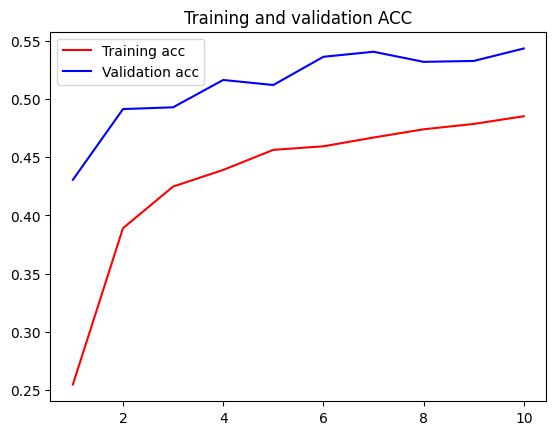

<Figure size 640x480 with 0 Axes>

In [55]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation ACC')
plt.legend()
plt.figure()

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# smooth curves if they look noisy
# replace each point with an exponential moving average of the previous points
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
plt.plot(epochs,
         smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

In [ ]:
plt.plot(epochs,
         smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# display average, the model may improve even if not reflected

# 6. Early stopping

In [ ]:
import keras
import os

callbacks_list = [
        # interrupts training when accuracy has stopped improving accuracy on the validation set for at least 3+1=4 epochs
        keras.callbacks.EarlyStopping(
            monitor='acc', # should be part of the metrics specific during compilation
            patience=6,
        ),
        # save the current weights after every epoch
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(paths['MODELS'],'CNN_baseline.h5'),
            monitor='val_loss', # do not overwrite until val_loss is improved
            save_best_only=True
        ),
        # monitor the model's validation loss and reduce the LR when the validation loss has stopped improving, effective strategy to escape local minima
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2, # divides LR by 5 when triggered
            patience=3 # called when stopped improving for 3 epochs
        ),
        keras.callbacks.TensorBoard(
            log_dir=paths['LOG_DIR'],
            write_graph=True,
            histogram_freq=1 # record activation histograms every 1 epoch
        )
]

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=3,
      epochs=5,
      validation_data=validation_generator,
      callbacks=callbacks_list,
      validation_steps=2)

# 7. Model testing

In [ ]:
test_dir=paths["TEST_PATH"]
test_datagen = ImageDataGenerator(rescale=rescale_size) # it should not be augmented

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(input_width, input_height), batch_size=batch_size, class_mode='categorical')

# if performances are much wors than validation ones, during hyperparameter optimization (when done) the process has overfitted the validdation set, if so go to a more clear protocol such as Kfold CV
test_loss, test_acc = model.evaluate_generator(test_generator, steps=2)
print('test acc:', test_acc)
print('test loss:', test_loss)

In [ ]:
# TODO: is it balanced? If not consider ROC AUC for example, FPR, TPR, and others

# 8. Model exportation

In [16]:
model.save("models/CNN_baseline.h5")

# 9. Plot model as graph of layers

In [ ]:
from keras.utils import plot_model

In [ ]:
plot_model(model, show_shapes=True, to_file='model.png')